In [1]:
import ast
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import os
import pandas as pd

from pathlib import Path

from src.utils.utils import GetSortedSpeciesCode

os.chdir('../')

In [2]:
TARGET_SPECIES = GetSortedSpeciesCode()

In [3]:
def filterTarget(l):
  res = []
  for x in l:
    if x in TARGET_SPECIES:
      res.append(x)
  return res

def countLabel(df:pd.DataFrame):
  spDict = {sp:0 for sp in TARGET_SPECIES}
  for _, row in df.iterrows():
    for sp in row['label']:
      if sp in TARGET_SPECIES:
        spDict[sp] += 1
  return spDict

In [4]:
df = pd.read_csv(Path.cwd().joinpath('data', 'LABEL_SEG.csv'), header=0)
df['label'] = df['label'].apply(lambda x: filterTarget(ast.literal_eval(x)))

xcDF = df[df['file'].str.contains('XC\d')]
mlDF = df[df['file'].str.contains('ML\d')]
selfDF = df[~df['file'].str.contains('ML\d|XC\d')]

xcLabel = countLabel(xcDF)
mlLabel = countLabel(mlDF)
selfLabel = countLabel(selfDF)

      XC   ML   SELF
AA   471  519   4608
AC   551  275   2963
BG   179  108   2306
CR   464  299   4786
FH   107  111   1768
HA   272  279   4529
LS   261  187   3001
ME   289   68    456
ML   155  151   2670
NV   541  712   4212
PA   376   90   2301
PAL  339  208   2878
PM   380  311   3956
PS     5    8    664
SE    74   26   1027
YB    84  129  10608


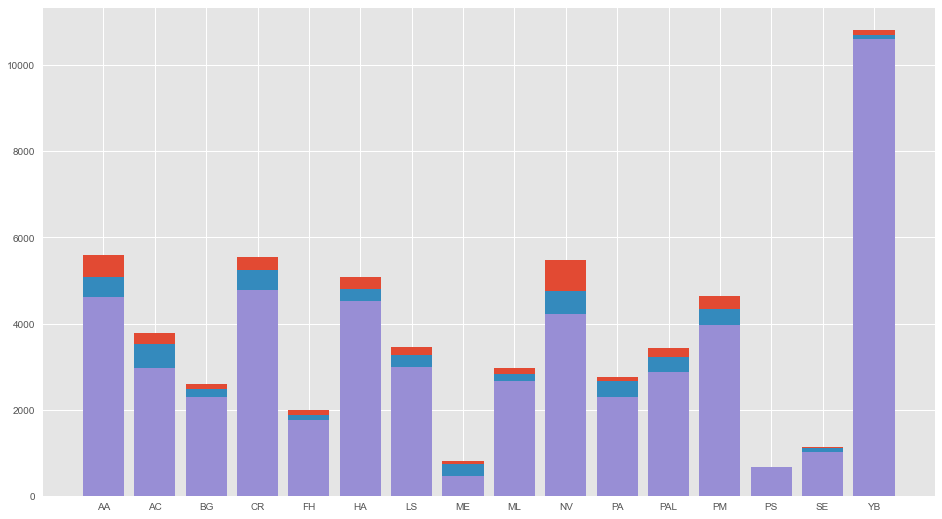

In [12]:
labelDF = pd.DataFrame.from_records(
  [xcLabel, mlLabel, selfLabel],
  index=['XC', 'ML', 'SELF']
)
labelDF = labelDF.T

plt.style.use('ggplot')
fig = plt.figure(figsize=(16, 9))
ax = plt.gca()
ax.bar(x=TARGET_SPECIES, height=labelDF['XC']+labelDF['ML']+labelDF['SELF'])
ax.bar(x=TARGET_SPECIES, height=labelDF['XC']+labelDF['SELF'])
ax.bar(x=TARGET_SPECIES, height=labelDF['SELF'])
print(labelDF)

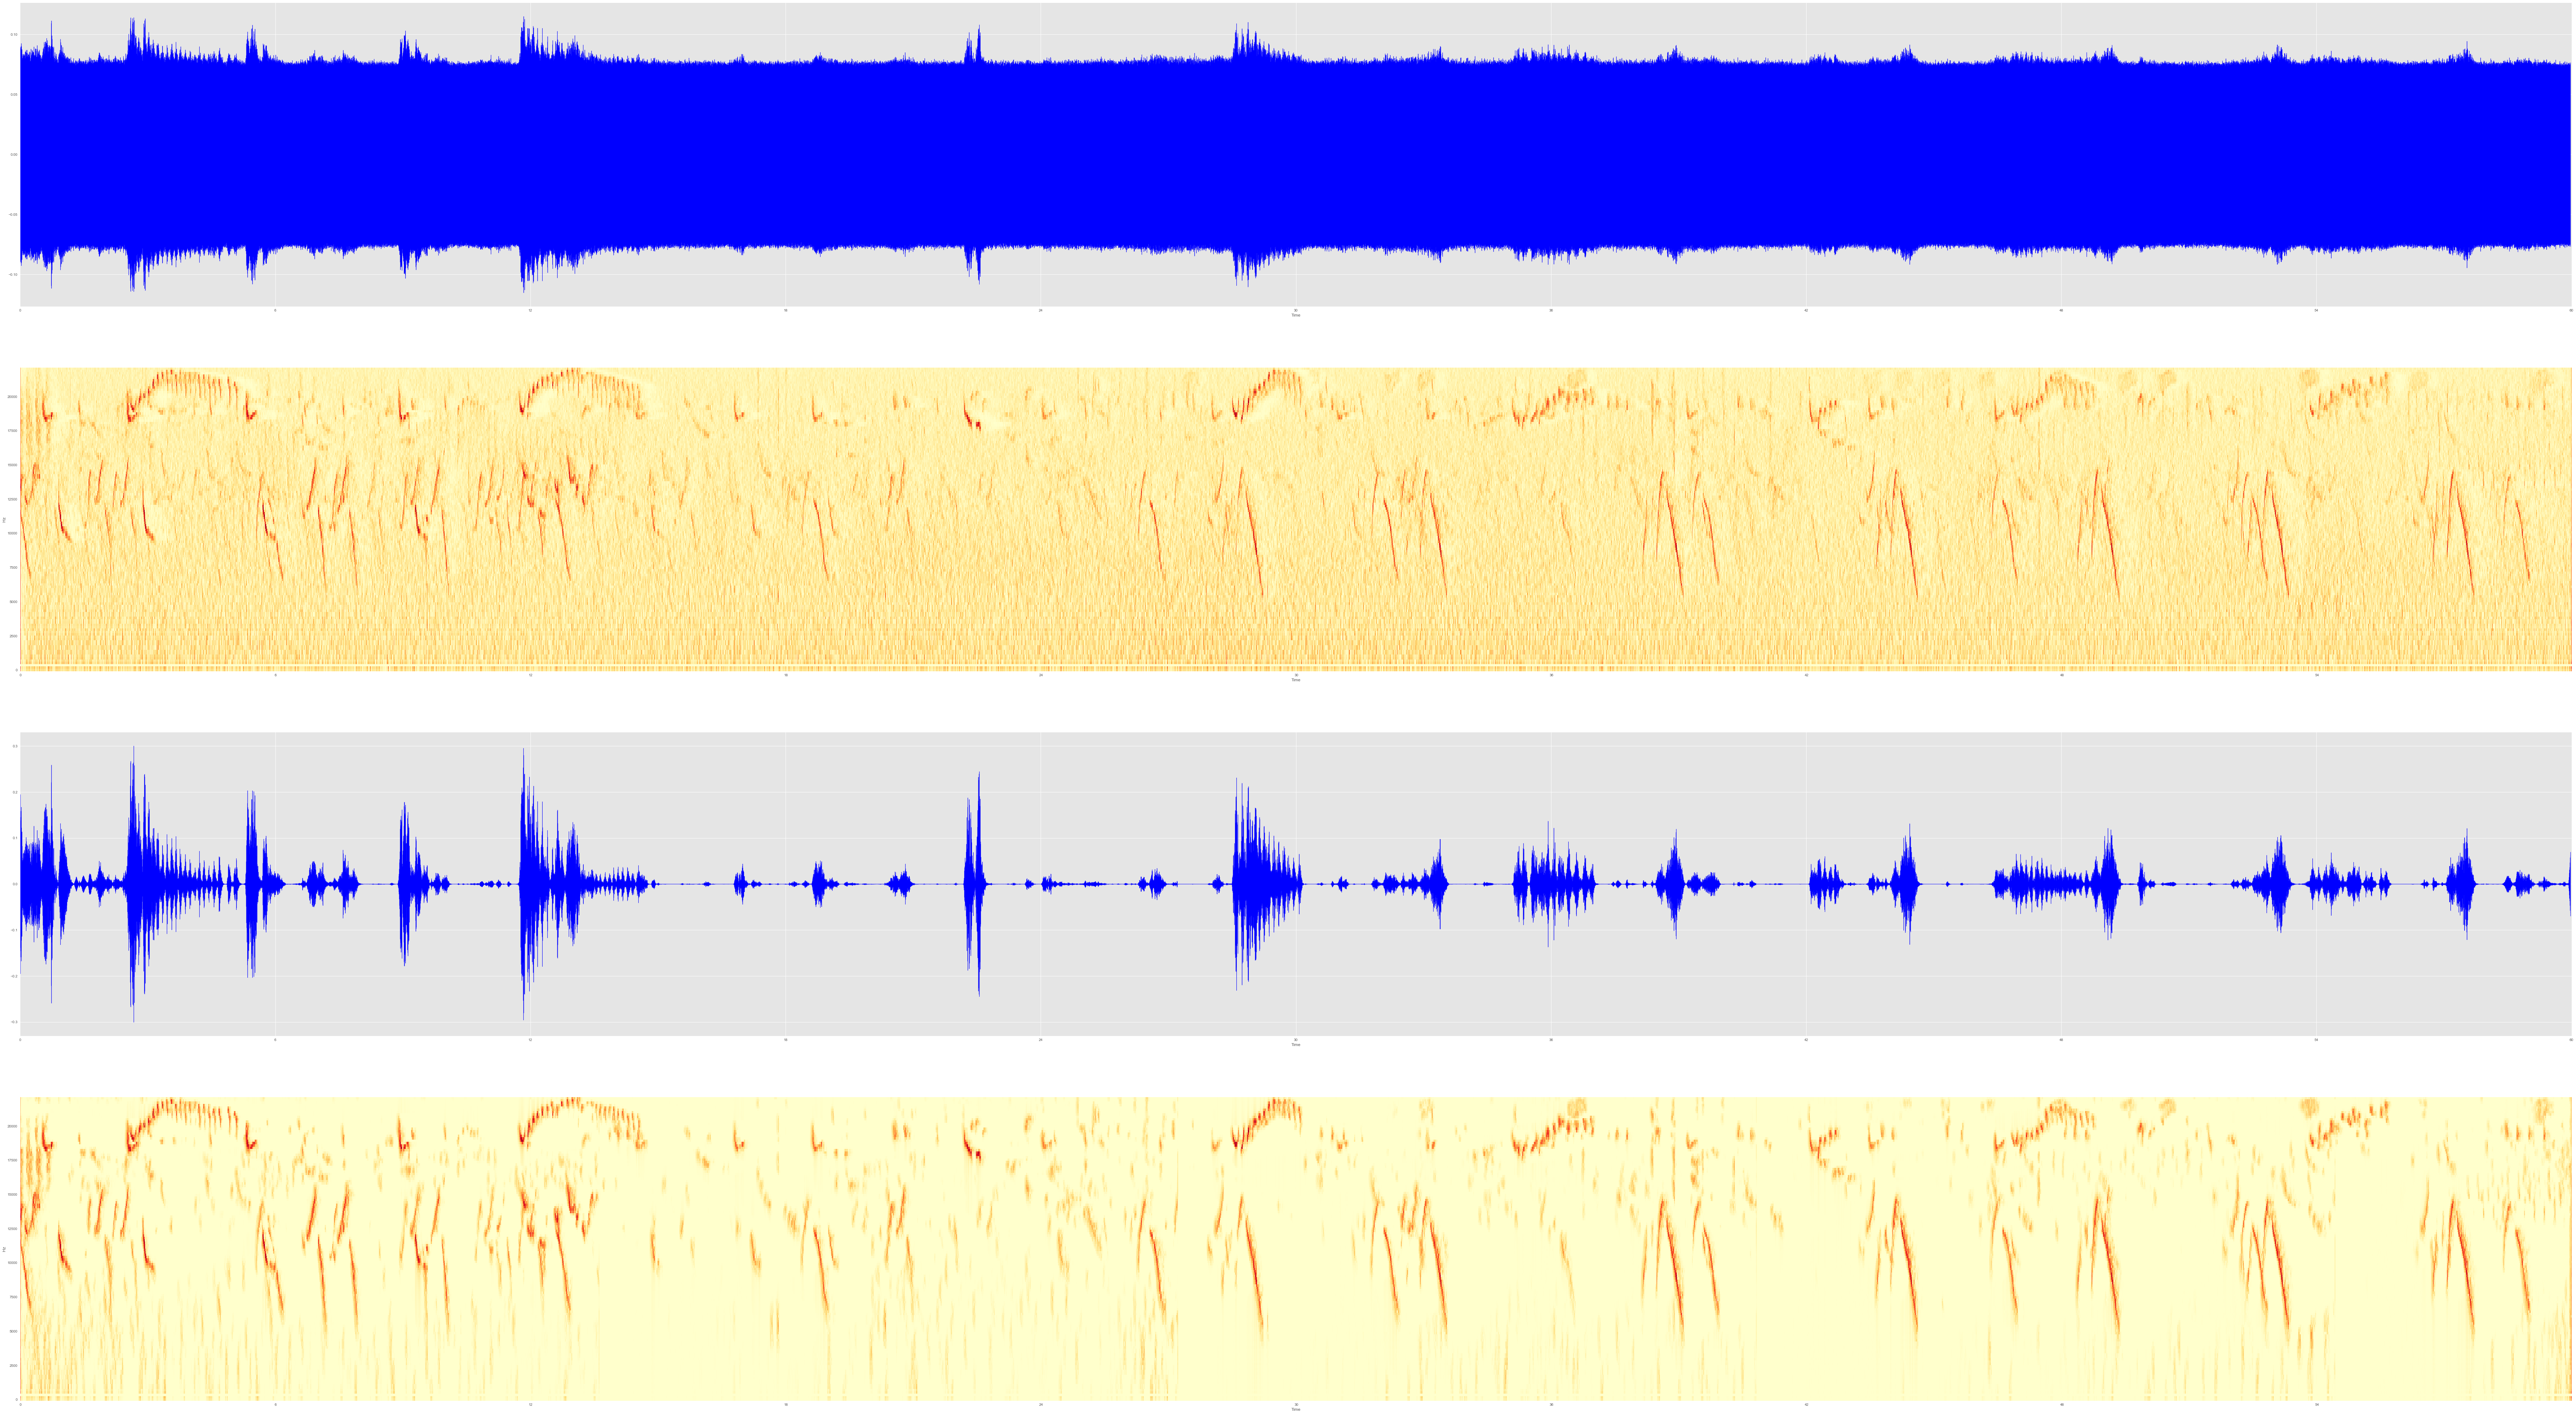

In [60]:
import librosa
import librosa.display

audio, sr = librosa.load(
  str(Path.cwd().joinpath('data', 'raw', 'GW01FOREST_20210401_060600.wav')),
  sr=None
)
nrAudio, sr = librosa.load(
  str(Path.cwd().joinpath('data', 'raw', 'NrAudio', 'GW01FOREST_20210401_060600.wav')),
  sr=None
)
mel = librosa.feature.melspectrogram(
  y=audio, sr=sr, n_fft=1024, hop_length=512, 
  n_mels=128, fmin=1000, fmax=10000
)
nrMel = librosa.feature.melspectrogram(
  y=nrAudio, sr=sr, n_fft=1024, hop_length=512, 
  n_mels=128, fmin=1000, fmax=10000
)
image = librosa.pcen(mel * (2**31), sr=sr, time_constant=0.06, gain=0.8, bias=10, power=0.25)
nrImage = librosa.pcen(nrMel * (2**31), sr=sr, time_constant=0.06, gain=0.8, bias=10, power=0.25)


fig, ax = plt.subplots(4, 1, figsize=(128, 72))
ax = ax.flatten()
librosa.display.waveshow(audio, sr=sr, ax=ax[0], color='b')
ax[0].set_xlim(0, 60)
librosa.display.specshow(
  image, y_axis='linear', x_axis='time',
  sr=sr, ax=ax[1], fmin=1000, fmax=10000, cmap='YlOrRd'
)
librosa.display.waveshow(nrAudio, sr=sr, ax=ax[2], color='b')
ax[2].set_xlim(0, 60)
librosa.display.specshow(
  nrImage, y_axis='linear', x_axis='time',
  sr=sr, ax=ax[3], fmin=1000, fmax=10000, cmap='YlOrRd'
)